# Music Alignment

In Music Alignment the goal is to match multiple versions of the same musical piece together, e.g. if you have a music performance as a MIDI file and a score in MusicXML, but you can do this with two audio-files, or one audio-file and one symbolic-music file as well. In our case, we perform an alignment of a music performance and the corresponding score in an offline scenario, thus the entire performance and the entire score is given to process and has not to be analysed in real-time when playing.

The musical performance and the score are given as CSV-files. At first an analysis is performed on the data to conclude the best method for music alignment.

## Importing Data

For importing the data, the method `load_dataset()` can be used from the challenge_utils.py file. This external python-file contains this method, which can be used to load an entire directory at once into python. E.g. in our case, we want to load the training-data which is stored in the folder "trainingset". In this folder, there are many subdirectories labelled by the name of the performance and the musical piece, e.g. "Chopin_op10_no3_p01" means, that the piece which is played is No3 of the 10th opus of Chopin and p01 means "performance01". In it, there is the "part"-file, which contains the score. The "ppart"-file (also performance-part) corresponds to the performed piano piece and the "align"-file corresponds to the ground-truth-alignment for training. The "zalign"-file has to be overwritten with our own alignment.

Generally, the data comes from the Vienna 4x22 dataset. This dataset contains 22 different performances of 4 different piano-pieces played by different pianists with different expressiveness (this is the reason for the name 4x22). Therefore, we can conclude, that the symbolic musical notes do not exceed the piano range of 88 keys, which is important for creating the music alignment model.

The import of the dataset with the function `load_dataset()` results in a dictionary, where the keys correspond to the names of the directories in the "trainingset" folder and the values to a tuple with 3 indices. Index 0 corresponds to the performance-csv-file, index 1 to the score-csv-file and index 2 to the ground-truth-alignment. In the following code-cells the numpy-representations are inspected more carefully.

In [1]:
import challenge_utils as cu

In [2]:
dataset = cu.load_dataset("trainingset")

In [3]:
performance_note_array = dataset["Chopin_op10_no3_p01"][0]

In [4]:
performance_note_array

array([( 4.9925 , 0.8775 , 59, 44, 0, 1, '0'),
       ( 5.7025 , 2.4375 , 40, 22, 0, 1, '1'),
       ( 5.70375, 2.43625, 64, 54, 0, 1, '2'),
       ( 5.77625, 2.36375, 56, 26, 0, 1, '3'),
       ( 6.4325 , 1.7075 , 47, 20, 0, 1, '4'),
       ( 6.44625, 1.69375, 59, 37, 0, 1, '5'),
       ( 6.9725 , 1.1675 , 63, 52, 0, 1, '6'),
       ( 7.0125 , 1.1275 , 56, 32, 0, 1, '7'),
       ( 7.47625, 0.66375, 64, 59, 0, 1, '8'),
       ( 7.5025 , 0.6375 , 59, 41, 0, 1, '9'),
       ( 7.51875, 0.62125, 47, 26, 0, 1, '10'),
       ( 8.03375, 4.20625, 66, 58, 0, 1, '11'),
       ( 8.06875, 2.04125, 35, 30, 0, 1, '12'),
       ( 8.06875, 4.17125, 63, 41, 0, 1, '13'),
       ( 8.09   , 0.625  , 57, 32, 0, 1, '14'),
       ( 8.70375, 1.40625, 47, 31, 0, 1, '15'),
       ( 8.73125, 1.37875, 59, 36, 0, 1, '16'),
       ( 9.2075 , 0.9025 , 57, 40, 0, 1, '17'),
       ( 9.66625, 0.4825 , 47, 30, 0, 1, '18'),
       ( 9.67   , 0.55375, 59, 44, 0, 1, '19'),
       (10.1375 , 2.1025 , 57, 39, 0, 1, '20'),
  

In [5]:
score_note_array = dataset["Chopin_op10_no3_p01"][1]

In [6]:
score_note_array

array([(-0.5 , 0.5 , -0.5 , 0.5 ,   0,  8, 59, 1, 'n1', '16'),
       ( 0.  , 1.  ,  0.  , 1.  ,   8, 16, 40, 7, 'n4', '16'),
       ( 0.  , 0.25,  0.  , 0.25,   8,  4, 56, 3, 'n3', '16'),
       ( 0.  , 0.5 ,  0.  , 0.5 ,   8,  8, 64, 1, 'n2', '16'),
       ( 0.25, 0.5 ,  0.25, 0.5 ,  12,  8, 47, 4, 'n6', '16'),
       ( 0.25, 0.25,  0.25, 0.25,  12,  4, 59, 3, 'n5', '16'),
       ( 0.5 , 0.25,  0.5 , 0.25,  16,  4, 56, 3, 'n8', '16'),
       ( 0.5 , 0.25,  0.5 , 0.25,  16,  4, 63, 1, 'n7', '16'),
       ( 0.75, 0.25,  0.75, 0.25,  20,  4, 47, 4, 'n11', '16'),
       ( 0.75, 0.25,  0.75, 0.25,  20,  4, 59, 3, 'n10', '16'),
       ( 0.75, 0.25,  0.75, 0.25,  20,  4, 64, 1, 'n9', '16'),
       ( 1.  , 1.  ,  1.  , 1.  ,  24, 16, 35, 7, 'n15', '16'),
       ( 1.  , 0.25,  1.  , 0.25,  24,  4, 57, 3, 'n14', '16'),
       ( 1.  , 1.5 ,  1.  , 1.5 ,  24, 24, 63, 2, 'n13', '16'),
       ( 1.  , 1.25,  1.  , 1.25,  24, 20, 66, 1, 'n12', '16'),
       ( 1.25, 0.5 ,  1.25, 0.5 ,  28,  8, 47, 4,

In [7]:
gt_alignment = dataset["Chopin_op10_no3_p01"][2]

In [8]:
gt_alignment

[{'label': 'match', 'score_id': 'n1', 'performance_id': '0'},
 {'label': 'match', 'score_id': 'n2', 'performance_id': '2'},
 {'label': 'match', 'score_id': 'n3', 'performance_id': '3'},
 {'label': 'match', 'score_id': 'n4', 'performance_id': '1'},
 {'label': 'match', 'score_id': 'n5', 'performance_id': '5'},
 {'label': 'match', 'score_id': 'n6', 'performance_id': '4'},
 {'label': 'match', 'score_id': 'n7', 'performance_id': '6'},
 {'label': 'match', 'score_id': 'n8', 'performance_id': '7'},
 {'label': 'match', 'score_id': 'n9', 'performance_id': '8'},
 {'label': 'match', 'score_id': 'n10', 'performance_id': '9'},
 {'label': 'match', 'score_id': 'n11', 'performance_id': '10'},
 {'label': 'match', 'score_id': 'n12', 'performance_id': '11'},
 {'label': 'match', 'score_id': 'n13', 'performance_id': '13'},
 {'label': 'match', 'score_id': 'n14', 'performance_id': '14'},
 {'label': 'match', 'score_id': 'n15', 'performance_id': '12'},
 {'label': 'match', 'score_id': 'n16', 'performance_id': '1

## Inspecting the data

When inspecting the score and the performance matrix, one can observe, that each note has a separate entry in form of a row inside the numpy-matrix. Basically the score and the performance are represented as an array of notes.

### Performance
The performance-numpy array consists of information about onset_sec, duration_sec, pitch, velocity, track, channel and id. "Onset" means the beginning of a note, e.g. if the pianist presses a key, the beginning of the note when its played is called "onset". After that the key is most likely hold for sometime on the piano, which is referred to as the duration. 

In the performance-numpy array onset and duration is defined in seconds. The pitch is an integer-number which corresponds to the pitch in the MIDI-convention. Velocity refers to another integer-number following the MIDI-convention representing how strong the key is pressed on the piano. The range is from 0 to 127 for both values, where 0 is the lowest pitch and strength-value and 127 the highest one.

Track and Channel are just meta-information about the MIDI-File, because MIDI-Files can be composed of multiple MIDI-Layers where each consists of different MIDI-notes played. E.g. you could divide the information of the upper and the lower hand into two different tracks. A channel corresponds to the output-instrument, e.g. if you have two instruments, they are divided into two channels. 

The last element, the ID, is a unique identifier for each note played in a piece.

As you can see, the most important information are the onset-time and the duration, as well as the pitch and velocity. This is used for music alignment.

### Score

The score also has onset- and duration-times, but in the score-representation the format are in "beats", "quarters" and "divs" (divisions). "onset_beat", "onset_quarter" and "onset_div" represents the same information just in different formats. 

"beats" refer to the individual beats in a musical score, where also negative values are allowed in the beginning of a piece to represent the upbeat before the piece starts with its measure, e.g. an upbeat could be 1/4 and then the piece continues in 4/4. A value of -1 would represent one beat before the actual start of the piece.

"quarters" are quarter-notes, as the name suggests. So a note with an onset of 1 would represent, that this note starts one quarter after the beginning. A duration of 0.5 in quarters would correspond to half a quarter, which is an eighth note.

"div" is a unit for division which is a metric also implemented in MusicXML and adapted for partitura. For notes to be specified in divisions, a second value has to be established, which is "div_pq". "div_pq" specifies how much a quarter note is further divided in, e.g. div_pq = 16 means, that the value 16 represents the duration of a quarter note. If now a note has duration 8, it is an eighth-note since 16 would correspond to a quarter note and half of it (16/2 = 8) is an eighth-note. Normally, div_pq can change in every bar and with this value every note has to be represented, such that the precision can vary for each bar.

Pitch is the same as in the performance, but now, there is a voice-column established. The voice is a tag of MusicXML representing a bunch of notes, rests, etc. which belongs together. You could e.g. divide the piano-clefs for melody and accompaniment into different voices, but in the base clef, there could be different elements belonging to different melodies itself, which can be further divided into voices. This feature is not strictly necessary but can provide useful musical information which cannot be explicitly encoded.

The ID serves the same purpose as in the performance-part and is an unique identifier.

### Ground-Truth-Alignment

The ground-truth-alignment is a list consisting of dictionaries always following the same structure. The first entry is called "label" and can take one out of three important values, namely "insertion", "deletion" and "match". "Insertion" refers to the fact, that in the performance there is a note inserted, which is not in the score and deletion is a note, which would be written in the score but was not played by the pianist. "Matches" are notes, which have been successfully matched between score and performance array.

## Computing Features for Music Alignment

From these different data-representations of score and performance, we can conclude, that in order to match notes of the score to the performance, we have to match representations first.

There are multiple ways to do that, e.g. training an auto-encoder to encode these features in the same format, but we decided against doing that, since neural networks do not know musical structure per se and would be uninformed function approximators. The most natural way to represent music is a visualization used in Digital Audio Workstations when editing MIDI-notes. It is called the "Piano Roll" and represents the musical piece on two axis in a cartesian coordinate system, where x is the time and y the midi-pitch. Internally, it is stored in a sparse matrix, since there are many zeros inside the array. This representation can be constructed with the score and the performance.

Piano Rolls can occur in different forms, e.g. they can represent only pitches, such that each pitch is represented within the same pitch-class (e.g. C1 and C2 would be treated the same) or they can distinguish between the actual ranges of the notes. They can also represent velocity-values or completely neglect them only considering binary values, where 0 represents a note not being played and 1 represents a note being played.

For generating Piano-Rolls out of note arrays, such those, which are given as training-data, the class "Partitura" is used.

### Partitura

`Partitura` is a package for Music Information Retrieval (MIR) of Symbolic Music. In general, in MIR tasks you want to automatically process symbolic music and therefore, you need to convert it into a format, algorithms can automatically understand. Importing symbolic music files in the original MIDI or MusicXML formats is not a good idea, since they contain much redundant information and in the end you want a representation in matrix form, which is not given by the original formats.

The goal of `Partitura` is to preprocess different symbolic music files and store them in a structured and similar way for all of these different sources within structured python objects. Furthermore, it provides many additional functions for preprocessing the data into different formats, e.g. to transform MIDI data into Piano Rolls. `Partitura` is divided into different modules, the `utils.music`-package contains a function for computing a piano-roll out of a note-array which is needed for our case.

Further tasks `Partitura` can handle are related to loading different symbolic music formats and computing different representations of it, e.g. extending the feature-columns to different properties of the loaded score-file in MusicXML, etc.

see paper: Cancino-Chacón, C. E., Peter, S. D., Karystinaios, E., Foscarin, F., Grachten, M., & Widmer, G. (2022). Partitura: A Python Package for Symbolic Music Processing. In Proceedings of the Music Encoding Conference (MEC2022). Halifax, Canada. (https://arxiv.org/abs/2206.01071)

The method `pt.utils.music.compute_pianoroll()` computes a piano-roll out of a note-array, where different parameters can be chosen.

Parameters:
1. `return_idxs`: represents a boolean-value. If this value is true, an additional array is returned containing the coordinates of each note in the computed piano-roll.
2. `remove_drums`: represents also a boolean-value and does not take drums into consideration. Since we only use classical piano pieces, this value is always set to True.
3. `end_time`: with this value, you could restrict the maximum length of the piece and truncate everything else. In our scenario this is not used due to a loss of information.
4. `time_unit` corresponds to a value for measuring duration and onset of notes when computing the piano roll. If "auto" is chosen score-note-arrays are using the "beat"-measure and performance-note-array the "sec"-measure. Out of this information of the notes, the piano roll is computed. 
5. `binary`: represents a boolean-value. If this is true, the velocity of notes is neglected and only 0 and 1 is used for velocity when computing the piano-roll, where 0 means that the note is not present and 1 means, that the note is present.
6. `time_div` is the accuracy of the piano-roll and the count of divisions within a time-unit (by default this is beat for scores and seconds for performances; see: `time_unit` = "auto")
7. `onset_only` = True means that the duration of a note is completely neglected and only the beginning of the note is used for computing the piano-roll.
8. `pitch_margin` and `time_margin` are two parameters which impose some contraints about the maximum time and range used. If a time-margin is established, for example, after a certain time, the piano-roll is not computed anymore, e.g. a few bars of the piece will not be present in the piano-roll. The same holds for the time_margin.
9. If `remove_silence` is true, the piece will not have any pauses before the start/onset of the first note.

In [9]:
import partitura as pt

In [10]:
score_pr, score_idx = pt.utils.music.compute_pianoroll(
    note_info=score_note_array,
    piano_range=True,
    return_idxs=True,
    remove_drums=True,
    end_time=None,              # piece will not be truncated
    time_unit="auto",           # must be set to auto, since the note_array-format depends on the performance/score
                    
    # parameters to change
    # binary = False,           # ensure a binary piano roll (either the node is pressed or not)
    # time_div = 24,            # sets the time division per time-unit
    # onset_only = False,  
    # pitch_margin = 0,
    # time_margin = 0,
    # remove_silence = False
)

In [11]:
performance_pr, performance_idx = pt.utils.music.compute_pianoroll(
    note_info=performance_note_array,
    piano_range=True,
    return_idxs=True,
    remove_drums=True,
    end_time=None,              # piece will not be truncated
    time_unit="auto",           # must be set to auto, since the note_array-format depends on the performance/score
                    
    # parameters to change
    # binary = False,           # ensure a binary piano roll (either the node is pressed or not)
    # time_div = 24,            # sets the time division per time-unit
    # onset_only = False,  
    # pitch_margin = 0,
    # time_margin = 0,
    # remove_silence = False
)

C:\Users\chfei\anaconda3\envs\miws23\lib\site-packages\partitura\utils\music.py:1296: UserWarning: Do not consider drum track for computing piano roll
  warnings.warn("Do not consider drum track for computing piano roll")


In [12]:
# is represented as a sparse matrix with many zeros in it
score_pr

<88x332 sparse matrix of type '<class 'numpy.intc'>'
	with 1430 stored elements in Compressed Sparse Column format>

In [13]:
# is represented as a sparse matrix with many zeros in it
performance_pr

<88x671 sparse matrix of type '<class 'numpy.intc'>'
	with 3634 stored elements in Compressed Sparse Column format>

This code-cell visualizes the computed piano-roll in `Matplotlib`.

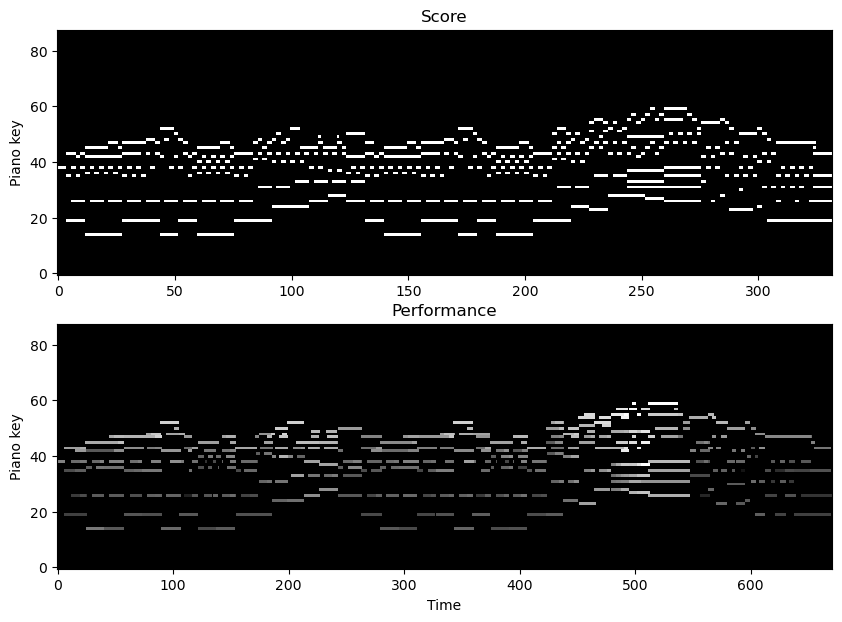

In [14]:
# code is part of the "Symbolic_Music_Alignment"-file

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, figsize=(10, 7))
axes[0].imshow(
    score_pr.todense(),
    aspect = "auto",
    origin="lower",
    cmap="gray",
    interpolation="nearest",
)
axes[1].imshow(
    performance_pr.todense(),
    aspect = "auto",
    origin="lower",
    cmap="gray",
    interpolation="nearest",
)
y_label = "Piano key"
axes[0].set_ylabel(y_label)
axes[1].set_ylabel(y_label)
axes[0].set_title("Score")
axes[1].set_title("Performance")
axes[1].set_xlabel("Time")
plt.show()

## Computing Alignments

After having computed two representations of score and performance that match in their quality, the next step is to match the individual notes, since this is the goal of Music Alignment.

This can be done in two steps without any Machine Learning Methods. The first one is to see the individual time-steps of both piano-rolls as two sequences. Mathematically, we want to match those two sequences in order to minimize a cost-function which represents the "error" of these two alignments. This can be done with Dynamic Time Warping, a dynamic programming technique, or similar algorithms, e.g. the Needleman-Wunsch Algorithm which can be modified for time warping also. Since Dynamic Time Warping minimizes the total cost-function, we have chosen also Dynamic Time Warping, which as an algorithm which takes two sequences following the same structure, which can be arbitrary. Therefore, there is only the cost-function to be chosen as a parameter, which can be any sort of distance (e.g. euclidian-distance, manhattan-distance, minkowski-distance (in the general case))

see paper: Peter, S. D., Cancino-Chacón, C. E., Foscarin, F., McLeod, A. P., Henkel, F., Karystinaios, E., & Widmer, G. (2023). Automatic Note-Level Scoreto-Performance Alignments in the ASAP Dataset. Transactions of the International Society for Music Information Retrieval, 6(1), 27–42. DOI: https://doi.org/10.5334/tismir.149

### Dynamic Time Warping

The package `fastdtw` implements a computationally faster version of dynamic time warping (DTW) which is more efficient for longer pieces to be aligned.

It takes two parameters:
1. `dist` represents the cost-measure of two musical entities of a the two sequences $X, Y$, we want to align, where these parameters p define the order of the corresponding minkowski-distance. If p=1, this corresponds to the manhattan-distance and if p=2, this corresponds to the euclidean-distance. $D\left(X,Y\right) = \biggl(\sum_{i=1}^n |x_i-y_i|^p\biggr)^{\frac{1}{p}}.$ 
(see https://en.wikipedia.org/wiki/Minkowski_distance)
2. `radius` specifies how many neighbors of the sequence (how many adjacent entities) are taken into account when calculating the optimal path between the two musical sequences after determining the distance-matrix. When this value is higher, the accuracy increases, but also the computational power needs to be higher.

In [15]:
# transformations on the piano-roll, such that it can be used by the fastdtw() function
score_features = score_pr.toarray().T
performance_features = performance_pr.toarray().T

In [16]:
from fastdtw import fastdtw
import numpy as np

dtwd, warping_path = fastdtw(score_features, performance_features, dist=2, radius=2)

# Make path a numpy array
warping_path = np.array(warping_path, dtype=int)

In [17]:
warping_path

array([[  0,   0],
       [  1,   1],
       [  2,   2],
       ...,
       [331, 668],
       [331, 669],
       [331, 670]])

### Greedy Note Alignment

The matching of time-step of the piano-rolls of score and performance is only the first part of Music Alignment, because, now we matched time-slices on the piano-roll where multiple notes can occur at once. 

Therefore, individual notes have to be matched as well, which can be done, e.g. by using a greedy algorithm which can work with a sliding window. If you have onset notes of the score, which are started to be played on timestep t, and you want to match them with the corresponding note of the performance, you look from timestep t-k to t+k to find it, where k is the window-size. The best matching note will be taken as the correct one, why it is called greedy note alignment. This is the most straight-forward-way to implement that, but can also lead to some accuracy-issues. You can also simplify this process by taking some additional assumptions, such that a note, which is matched to another one must have the same pitch.

In [18]:
from typing import List

def greedy_note_alignment(
    warping_path: np.ndarray,
    idx1: np.ndarray,
    note_array1: np.ndarray,
    idx2: np.ndarray,
    note_array2: np.ndarray,
) -> List[dict]:
    """
    Greedily find and store possible note alignments

    Parameters
    ----------
    warping_path : numpy ndarray
        alignment sequence idx in stacked columns
    idx1: numpy ndarray
        pitch, start, and end coordinates of all notes in note_array1
    note_array1: numpy structured array
        note_array of sequence 1 (the score)
    idx2: numpy ndarray
        pitch, start, and end coordinates of all notes in note_array2
    note_array2: numpy structured array
        note_array of sequence 2 (the performance)

    Returns
    ----------
    note_alignment : list
        list of note alignment dictionaries

    """
    note_alignment = []
    used_notes1 = []
    used_notes2 = []

    coord_info1 = idx1
    if idx1.shape[1] == 3:
        # Assume that the first column contains the correct MIDI pitch
        coord_info1 = np.column_stack((idx1, idx1[:, 0]))

    coord_info2 = idx2

    if idx2.shape[1] == 3:
        # Assume that the first column contains the correct MIDI pitch
        coord_info2 = np.column_stack((idx2, idx2[:, 0]))

    # loop over all notes in sequence 1
    for note1, coord1 in zip(note_array1, coord_info1):
        note1_id = note1["id"]
        pc1, s1, e1, pitch1 = coord1

        # find the coordinates of the note in the warping_path

        idx_in_warping_path = np.all(
            [warping_path[:, 0] >= s1, warping_path[:, 0] <= e1], axis=0
        )
        # print(idx_in_warping_path, idx_in_warping_path.shape)
        range_in_sequence2 = warping_path[idx_in_warping_path, 1]
        max2 = np.max(range_in_sequence2)
        min2 = np.min(range_in_sequence2)

        # loop over all notes in sequence 2 and pick the notes with same pitch
        # and position
        for note2, coord2 in zip(note_array2, coord_info2):
            note2_id = note2["id"]
            pc2, s2, e2, pitch2 = coord2
            if note2_id not in used_notes2:
                if pitch2 == pitch1 and s2 <= max2 and e2 >= min2:
                    note_alignment.append(
                        {
                            "label": "match",
                            "score_id": note1_id,
                            "performance_id": str(note2_id),
                        }
                    )
                    used_notes2.append(str(note2_id))
                    used_notes1.append(note1_id)

        # check if a note has been found for the sequence 1 note,
        # otherwise add it as deletion
        if note1_id not in used_notes1:
            note_alignment.append({"label": "deletion", "score_id": note1_id})
            used_notes1.append(note1_id)

    # check again for all notes in sequence 2, if not used,
    # add them as insertions
    for note2 in note_array2:
        note2_id = note2["id"]
        if note2_id not in used_notes2:
            note_alignment.append(
                {
                    "label": "insertion",
                    "performance_id": str(note2_id),
                }
            )
            used_notes2.append(str(note2_id))

    return note_alignment

In [19]:
predicted_alignment = greedy_note_alignment(
                    warping_path=warping_path,
                    idx1=score_idx,
                    note_array1=score_note_array,
                    idx2=performance_idx,
                    note_array2=performance_note_array,
)

In [20]:
predicted_alignment

[{'label': 'match', 'score_id': 'n1', 'performance_id': '0'},
 {'label': 'match', 'score_id': 'n4', 'performance_id': '1'},
 {'label': 'match', 'score_id': 'n3', 'performance_id': '3'},
 {'label': 'match', 'score_id': 'n2', 'performance_id': '2'},
 {'label': 'match', 'score_id': 'n6', 'performance_id': '4'},
 {'label': 'match', 'score_id': 'n5', 'performance_id': '5'},
 {'label': 'match', 'score_id': 'n8', 'performance_id': '7'},
 {'label': 'match', 'score_id': 'n7', 'performance_id': '6'},
 {'label': 'match', 'score_id': 'n11', 'performance_id': '10'},
 {'label': 'match', 'score_id': 'n10', 'performance_id': '9'},
 {'label': 'match', 'score_id': 'n9', 'performance_id': '8'},
 {'label': 'match', 'score_id': 'n15', 'performance_id': '12'},
 {'label': 'match', 'score_id': 'n15', 'performance_id': '21'},
 {'label': 'match', 'score_id': 'n14', 'performance_id': '14'},
 {'label': 'match', 'score_id': 'n13', 'performance_id': '13'},
 {'label': 'match', 'score_id': 'n13', 'performance_id': '2

## Improvement Phases

The stated implementation of Music-Alignment only served as a blueprint for further experiments.

### Improvements Phase 1 - Hyperparameter-Search

In the first initial improvement phase, a Hyperparameter-Search for the individual values which are part of the given pipeline, was conducted. As stated before, we did not change anything of the steps, because of the following reasons: The initial computation of the features of the score and the performance array is necessary, because of the structural differences between these arrays. The most natural way to represent music is used by a piano-roll, such that we did not let an uninformed neural-network do the feature-encoding. 

After that, an alignment algorithm needs to be chosen and since Dynamic Time Warping calculates the optimal path under certain constraints, it serves as a good option. The greedy-note alignment is not optimal, which was also the reason for another improvement phase.

#### Defining the Parameter Space

A hyperparameter search is conducted by defining the parameters of the pipeline, we want to try out altering. In general, a hyperparameter-search is rather a try-and-error procedure with some expert knowledge we can apply to choose certain parameters with some informed knowledge. In this process, the main goal is to try out different alternatives for different parameters to check, which parameters deliver the best results evaluated by a specific metric. In our case, this is the F1-Score for the predicted musical alignment.

In our scenario, the parameters we have chosen are defined by the API of the `pt.utils.music.compute_pianoroll()` method, and the `fastdtw()` method, which are explained in the corresponding sections in this documentation.

The first five parameters correspond to the `pt.utils.music.compute_pianoroll()`-method and the last parameter is part of the `fastdtw()`-method:

1. `binary`: represents a boolean-value. If this is true, the velocity of notes is neglected and only 0 and 1 is used for velocity when computing the piano-roll, where 0 means that the note is not present and 1 means, that the note is present.
2. `time_div` is the accuracy of the piano-roll and the count of divisions within a time-unit (by default this is beat for scores and seconds for performances; see: `time_unit` = "auto")
3. `onset_only` = True means that the duration of a note is completely neglected and only the beginning of the note is used for computing the piano-roll.
4. `pitch_margin` and `time_margin` are two parameters which impose some contraints about the maximum time and range used. If a time-margin is established, for example, after a certain time, the piano-roll is not computed anymore, e.g. a few bars of the piece will not be present in the piano-roll. The same holds for the time_margin. Since a restriction in the pitch and time always leads to a loss of information, these values needs to be chosen carefully or completely not considered.
5. If `remove_silence` is true, the piece will not have any pauses before the start/onset of the first note.
6. The `dist` represents the cost-measure of two musical entities of a the two sequences $X, Y$, we want to align, where these parameters p define the order of the corresponding minkowski-distance. If p=1, this corresponds to the manhattan-distance and if p=2, this corresponds to the euclidean-distance. $D\left(X,Y\right) = \biggl(\sum_{i=1}^n |x_i-y_i|^p\biggr)^{\frac{1}{p}}.$ 
(see https://en.wikipedia.org/wiki/Minkowski_distance)
7. `radius` specifies how many neighbors of the sequence (how many adjacent entities) are taken into account when calculating the optimal path between the two musical sequences after determining the distance-matrix. When this value is higher, the accuracy increases, but also the computational power needs to be higher.

#### Notes on the chosen parameters

Why we have chosen these parameters and not the other, is due to the fact, that the other parameters of the API of the `pt.utils.music.compute_pianoroll()` offer only settings, which are already fixed regarding our specific Music Alignment Task.

1. `note_info` is a parameter which specifies the note-array that should be converted into the piano-roll. This cannot be changed, since this is input-feature-matrix.
2. `return_idx` returns an additional array containing the coordinates of each note in the computed piano-roll if this value is set to True. This additional array is not needed for the music-alignment-computation.
3. `piano_range` defines whether the given data is in the MIDI-range of an 88-key-piano. Since this is true, this boolean-value is also fixed to True.
4. `time_unit` specifies the time-unit which is used in the given note-array to compute the piano-roll from. This can be done automatically by setting this value to `auto`, which simplifies this process, because score-note array and performance-note array are using different values.
5. `end_time` is set to None, since we do not want to restrict the piano-roll in length and introduce some precision-error.
6. `remove_drums` is set to True, since we do not use any drums in our alignments.

Everything other parameter is at least tried out for the hyperparameter-tuning. Note that `time_margin` and `pitch_margin` could also introduce some precision-errors, but in the tuning-process these parameters can take the value 0 or -1 which means, that this has no effect in these parameter-configurations.

The `fast_dtw()`-method only allows to specify the `distance`-measure and the `radius`.

#### Implemention of the parameter-space

In the following way, a parameter-space can be defined as a dictionary. The keys represent the parameters, we want to try out and the values corresponds to list of values, which we want to test. Then this dictionary is converted automatically into a list of tuples with the `itertools`-package of python. Each tuple represents one value-combination, we want to try.

The only thing one need to keep in mind is, that the algorithm needs to try out each combination of these parameters, why we need to be careful, not choosing too much values, due to the combinatorial explosion issue.

In [21]:
param_space = {
                "is_binary": [False, True],    
               "time_div": [24, 48, 96],
               "onset_only": [False, True],
               "pitch_margin": [-1, 0, 5],
               "time_margin": [0, 5],
               "remove_silence": [False],
               "distance": [1, 2, 3],
                "radius": [1, 2, 3]
               }

import itertools as it

combinations_param = it.product(*(param_space[item] for item in param_space))
combination_list = list(combinations_param)

Here, you can see, that even if each parameter on its own has few values on each own, the number of combination is quite huge:

In [22]:
len(combination_list)

648

This is the beginning of the list, representing the first 10 tuples.

In [23]:
combination_list[0:10]

[(False, 24, False, -1, 0, False, 1, 1),
 (False, 24, False, -1, 0, False, 1, 2),
 (False, 24, False, -1, 0, False, 1, 3),
 (False, 24, False, -1, 0, False, 2, 1),
 (False, 24, False, -1, 0, False, 2, 2),
 (False, 24, False, -1, 0, False, 2, 3),
 (False, 24, False, -1, 0, False, 3, 1),
 (False, 24, False, -1, 0, False, 3, 2),
 (False, 24, False, -1, 0, False, 3, 3),
 (False, 24, False, -1, 5, False, 1, 1)]

#### Defining a pipeline for hyperparameter-tuning

Before being able to tune hyperparameters, we need to specify a pipeline-function, which takes as an input the different hyperparameter-configurations and the dataset. This function applies all the necessary steps for musical alignment with all the configurations provided. After that some metrics will evaluate how good this parameter-configuration was on the given data with the provided pipeline. In our case this is the F1-Score, the Precision-Score and the Recall-Score which compares the ground-truth alignment and the predicted alignment. For calculating the scores, the function `compare_alignments()` of the `challenge_utils`-package is provided.

Additionally, we do not want to apply the hyperparameter-tuning only on one musical-piece of the dataset, but on multiple ones to avoid bias when evaluating the parameter-configuration. But our computational power is not big enough to handle the complete training-dataset for all the configurations possible. Therefore, not only the complete dataset is provided in dictionary `dataset`, but also a `performance_string_list`. This list contains the keys for the dictionary `dataset` of the performances we want to put into the pipeline with the given parameter-configuration.

In principle, in the `music_alignment_pipeline()`-function there are two nested loops implemented. One looping over the parameter-configuration. For each parameter-configuration we also need to put all the different performances of `performance_string_list` into the pipeline, such that another for-loop has to be introduced.

The return value of this function is a dictionary containing all the three metrics. As a key, you can input the tuple which represents the parameter-configuration, and the value is a list. This list contains tuples as entries, where the first element is the string of the name of the musical performance which is evaluated with the current parameter-configuration and the second element is another tuple containing the three different metrics. 

After putting through every musical performance into the pipeline with one parameter-configuration, an average (arithmetic mean) of these values will be calculated. This is also stored in the dictionary as the last entry of the list.

During training, the F1-Scores will be printed to immediately see the evaluation for the different hyperparameter-configurations on the different pieces.

An important note is, that the combination-tuples in the `combinations`-list must correspond to the following format (specified in the section before):
(`is_binary`, `time_div`, `onset_only`, `pitch_margin`, `time_margin`, `remove_silence`, `distance`, `radius`)

In [24]:
# imports the function which is providing the evaluation of the generated musical alignment with the ground-truth-alignment
from challenge_utils import compare_alignments

In [25]:
def music_alignment_pipeline(dataset: dict, performance_string_list: list, combinations: list) -> dict:
    """
    Parameters
    ----------
    dataset is a dictionary that contains the data of all the scores and the corresponding performances, as well as the ground-truth alignment. the key corresponds to a string identifying the musical piece
    performance_string_list is a list of strings which corresponds to some of the keys of the dataset dictionary representing performances. these performances will be used to evaluate when putting them into the pipeline
    combinations is a list with tuples representing the different hyperparameter-configurations: these tuples must correspond to the specification of the parameter-space in the section before

    Returns
    -------
    dict: evaluations of the different hyperparameter-configurations
    """
    
    
    # dictionary "scores" stores results
    # key: (item_1, item_2, ..., item_n) 
    # value: [(<Name of Piece 1>, ((<F1-Score>), (<Precision-Score>), (<Recall-Score>))), 
    #         (<Name of Piece 2>, ((<F1-Score>), (<Precision-Score>), (<Recall-Score>)))
    #         (<Name of Piece 3>, ((<F1-Score>), (<Precision-Score>), (<Recall-Score>)))
    #          ...
    #         (<Name of Piece n>, ((<F1-Score>), (<Precision-Score>), (<Recall-Score>)))
    #         ("Average", ((<F1-Score Avg.>), (<Precision-Score Avg.>), (<Recall-Score Avg.>)))]
    scores = {}
    
    # stores the best f1-score average
    best_f1_score_avg = 0
    # and the best hyperparameter-configuration so far
    best_item_avg = None
    
    # goes through every hyperparameter-combination
    for item in combinations:
        print("##############################")
        print(f"Start of processing hyperparameter-configuration {item}... \n\n")
        scores[item] = []
        
        # goes through every piece in "performance_string_list"
        for performance in performance_string_list:
            
            # extraction of the score-note-array, performance-note-array and ground-truth-alignment
            score_note_array, performance_note_array, gt_alignment = dataset[performance][1], dataset[performance][0], dataset[performance][2]
            
            # extraction of the arguments of the current combination
            is_binary = item[0]
            time_div = item[1]
            onset_only = item[2]
            pitch_margin = item[3]
            time_margin = item[4]
            remove_silence = item[5]
            distance = item[6]
            radius = item[7]
            
            #### START OF MUSIC ALIGNMENT PIPELINE ####
            
            ### calculation of piano-roll-features ###
            score_features, score_idx = pt.utils.music.compute_pianoroll(
                # fixed parameters
                note_info=score_note_array,
                return_idxs=True,
                piano_range=True, 
                time_unit="auto",
                end_time=None,             
                remove_drums=True,
                
                # parameters to change
                binary = is_binary,        
                time_div = time_div,  
                onset_only = onset_only,  
                pitch_margin = pitch_margin,
                time_margin = time_margin,
                remove_silence=remove_silence
            )
            score_features = score_features.toarray().T
                
            performance_features, performance_idx = pt.utils.music.compute_pianoroll(
                # fixed parameters
                note_info=performance_note_array,
                return_idxs=True,
                piano_range=True,
                time_unit="auto",
                end_time=None,
                remove_drums=True,
                    
                # parameters to change
                binary = is_binary,
                time_div=time_div,
                onset_only=onset_only,
                pitch_margin = pitch_margin,
                time_margin = time_margin,
                remove_silence = remove_silence
            )
            performance_features = performance_features.toarray().T
            
            ### calculation of the sequence alignment ###
            dtwd, warping_path = fastdtw(score_features, performance_features, 
                                         dist=distance, radius=radius) # parameters to change
            warping_path = np.array(warping_path, dtype=int)
            
            ### calculation of the greedy note alignment ###
            predicted_alignment = greedy_note_alignment(
                    warping_path=warping_path,
                    idx1=score_idx,
                    note_array1=score_note_array,
                    idx2=performance_idx,
                    note_array2=performance_note_array,
            )
            
            #### END OF MUSIC ALIGNMENT PIPELINE ####
            
            # returns a tuple with 3 metrics (F1-Score, Precision-Score, Recall-Score)
            # for the current score with the current hyperparameter configuration
            piece_eval = compare_alignments(
                prediction=predicted_alignment,
                ground_truth=gt_alignment,
            )
            
            # prints the f1-score with the current hyperparameter-combination for the current piece
            print(f"Scores for {item} in {performance}:")
            print(piece_eval[0], "\n")
           
            scores[item].append((performance, piece_eval))
        
        
        ### Averaging Scores for the current hyperparameter configuration ###
        
        avg_f1_score = 0
        avg_precision_score = 0
        avg_recall_score = 0
        
        temp_scores = scores[item]
        for t in temp_scores:
            # score_str = t[0]
            score_eval = t[1]
            
            avg_f1_score += score_eval[0]
            avg_precision_score += score_eval[1]
            avg_recall_score += score_eval[2]
        
        avg_f1_score = avg_f1_score / len(temp_scores)
        avg_precision_score = avg_precision_score / len(temp_scores)
        avg_recall_score = avg_recall_score / len(temp_scores)
        
        avg_score_tuple = (avg_f1_score, avg_precision_score, avg_recall_score)
        scores[item].append(("Average", avg_score_tuple))
        
        ### Averaging Scores for the current hyperparameter configuration ###
        
        
        # prints the average f1-score with the current hyperparameter-combination
        print(f"Average-F1-Score for {item}: {avg_f1_score} \n\n")
        
        print(f"End of processing hyperparameter-configuration {item}...")
        print("############################## \n\n")
        
        # stores the current average f1-score of the current hyperparameter-configuration
        # if it is better than the best one so far
        if avg_f1_score > best_f1_score_avg:
            best_f1_score_avg = avg_f1_score
            best_item_avg = item
        
    # prints the best results after the hyperparameter search
    print(f"Best Average-F1-Score: {best_f1_score_avg} \n")
    print(f"Best Combination: {best_item_avg} \n")
        
    return scores

In [26]:
pieces =  [ "Chopin_op10_no3_p02", "Chopin_op10_no3_p13", 
            "Chopin_op38_p05", "Chopin_op38_p19",
            "Mozart_K331_1st-mov_p08", "Mozart_K331_1st-mov_p22",
            "Schubert_D783_no15_p11", "Schubert_D783_no15_p20" ]

In [27]:
results = music_alignment_pipeline(dataset, pieces, combination_list)

##############################
Start of processing hyperparameter-configuration (False, 24, False, -1, 0, False, 1, 1)... 


C:\Users\chfei\anaconda3\envs\miws23\lib\site-packages\partitura\utils\music.py:1296: UserWarning: Do not consider drum track for computing piano roll
  warnings.warn("Do not consider drum track for computing piano roll")


Scores for (False, 24, False, -1, 0, False, 1, 1) in Chopin_op10_no3_p02:
0.791497975708502 
Scores for (False, 24, False, -1, 0, False, 1, 1) in Chopin_op10_no3_p13:
0.797979797979798 
Scores for (False, 24, False, -1, 0, False, 1, 1) in Chopin_op38_p05:
0.015455950540958269 


KeyboardInterrupt: 

#### Observations with Hyperparameter Tuning

As you can see in the printed results, the scores for the Chopin-Piece op10 no3 were quite good, but unfortunately the performance dropped quite significantly for the other pieces. Therefore, we had to come up with a different approach...

### Improvements Phase 2 - Research

After checking, if the baseline could give already decent results, we took some research in the field of Music Alignment and stumbled across different papers.

#### Implementation of Nakamura, E., Yoshii

One of them was written by Nakamura, E., Yoshii et al., where Music Alignment is essentially performed in three different steps. One of them is the pre-processing-phase, where it is tried to correct player-mistakes. Sometimes player-mistakes in the beginning of a piece can lead to mis-alignments of the notes afterward, since this can cause continuing errors. This might also be the reason, why the base-line-method did not work out as good as we have thought. Only after that, the alignment is done and in the end, some post-processing is applied to correct the alignment. The main ingredient of this approach are hidden-markov-models. 

The approach of this paper was the best one regarding music alignments a long time and there is a version implemented C++ online at the following link: https://midialignment.github.io/demo.html.

But then we have found another paper by the Institute of Computational Perception at the Johannes Kepler University in Austria, Linz.

see paper: Nakamura, E., Yoshii, K., and Katayose, H. (2017). Performance error detection and post-processing for fast and accurate symbolic music alignment. In Proceedings of the International Society for Music Information Retrieval Conference (ISMIR), pages 347–353, Suzhou, China., https://eita-nakamura.github.io/articles/EN_etal_ErrorDetectionAndRealignment_ISMIR2017.pdf


#### Implementation of Automatic-Note-Level Alignment (Institute of Computational Perception)

In this paper, the authors proposed different techniques for musical alignment which are built upon the Dynamic Time Warping of the baseline, but also different variations of them. E.g. you could also use the Needleman-Wunsch-Algorithm, which is known in the field of bioinformatics, where you want to align DNA-sequences. This can be adapted to the field of music with some adaptations regarding this field, which is called Needleman-Wunsch-Time-Warping. The main goal of this paper was to establish algorithms which could align the so-called ASAP-Dataset (https://github.com/fosfrancesco/asap-dataset), which is one of the biggest dataset containing different musical performances of a few musical pieces with musical alignments, but the individual notes are not aligned. This paper also extended this dataset to the (n)ASAP-dataset with some additional note-alignments: https://github.com/CPJKU/asap-dataset

There is also a reference to this link included: https://github.com/sildater/parangonar. It is a library called `Parangonar`, which provides various functions for Music-Alignment: One of them is the `AutomaticNoteMatcher()` which can provide musical note-alignments without additional musical annotations. In principle, the task of musical-alignment can be simplified, if there are additional information provided of the score and the performance. E.g. beat tapping, a task where people listen to music and tap according to the beat, can help, if you record this data and use it as an additional source for the musical alignment. The special thing of this library is that there are different algorithms implemented with different use-cases, e.g. there is a dedicated, specialized algorithm for alignment, if such information is available or not. 

If you have grace-notes (notes which are played quickly before another note) separately stored, then `DualDTWNoteMatcher()` is the best option. The `AnchorPointNoteMatcher()` is used, if there is additional information about anchor points. Anchor Points are time-stamp-windows in the piece, in which the note-alignment should be performed, following the assumption, that it is very likely, that notes which are potential candidates to be matched, are played not too far apart. If anchor-points are introduced, alignment-errors will not be propagated outside of these anchors. 

Even some online-note-matching-algorithms are provided as part of `OnlineTransformerMatcher()` and `OnlinePureTransformerMatcher()`, which are not needed for our task now.

see paper: Peter, S. D., Cancino-Chacón, C. E., Foscarin, F., McLeod, A. P., Henkel, F., Karystinaios, E., & Widmer, G. (2023). Automatic Note-Level Scoreto-Performance Alignments in the ASAP Dataset. Transactions of the International Society for Music Information Retrieval, 6(1), 27–42. DOI: https://doi.org/10.5334/tismir.149

#### Automatic Note Matcher

The `AutomaticNoteMatcher()` of the `Parangonar`-Package can be called without any parameters, and delivers very good results out of the box with the default-settings. We tried it on Performance 11 on the Schubert D783 No15 Piece (Schubert_D783_no15_p11), where the results were not very good with the baseline-algorithm.

In [28]:
# extraction of the performance note array
pna_schubert_D783_no15_p11 = dataset["Schubert_D783_no15_p11"][0]

# extraction of the score note array
sna_schubert_D783_no15_p11 = dataset["Schubert_D783_no15_p11"][1]

# extraction of the ground truth alignment
gt_align_schubert_D783_no15_p11 = dataset["Schubert_D783_no15_p11"][2]

At first, the `parangonar`-package has to be imported and an object of the `AutomaticNoteMatcher` class has to be initialized. Possible parameters can be set when creating this object.

In [29]:
import parangonar as pa
anm = pa.AutomaticNoteMatcher()

In [30]:
# if verbose_time is set to True, the method prints out a log into the console with some time statistics
pred_alignment_schubert_D783_no15_p11 = anm(sna_schubert_D783_no15_p11 , 
                     pna_schubert_D783_no15_p11,
                     verbose_time=True)

1.528 sec : Initial coarse DTW pass
0.005 sec : Cutting
0.957 sec : Fine-grained DTW passes, symbolic matching
0.016 sec : Mending


There is also another function of the `Parangonar`-package, which is called `fscore_alignments()`. This takes a predicted alignment, and the ground-truth and compares them. There is also a third parameter for specifying the alignment-type, which checks the alignment only regarding different aspects, namely `match`, `insertion` and `deletion`. If this parameter is specified, then only matching-notes, insertion-notes and/or deletion-notes will be compared regarding f1-score.

This code is provided by the Parangonar-GitHub-Repository at https://github.com/sildater/parangonar.

In [31]:
types = ['match','insertion', 'deletion']
for alignment_type in types:
    precision, recall, f_score = pa.fscore_alignments(pred_alignment_schubert_D783_no15_p11, gt_align_schubert_D783_no15_p11, alignment_type)
    
    print('Evaluate ',alignment_type)
    print('Precision: ',format(precision, '.3f'),
          'Recall ',format(recall, '.3f'),
          'F-Score ',format(f_score, '.3f'))
    
    print('------------------')

Evaluate  match
Precision:  0.966 Recall  0.969 F-Score  0.967
------------------
Evaluate  insertion
Precision:  0.250 Recall  0.222 F-Score  0.235
------------------
Evaluate  deletion
Precision:  0.778 Recall  0.700 F-Score  0.737
------------------


#### Observations

As you can see, the results above are very good and can be seen in comparison with other Music-Alignment-Methods. Therefore, we played around with the interface of the `AutomaticNoteMatcher`-constructor and tried out different parameters.

Basically the `AutomaticNoteMatcher` is only an alias for the `PianoRollNoNodeMatcher`-class, when examining the source-code.

The `inspect`-package of python allows to print out the source-code of the individual classes.

In [32]:
import inspect
print(inspect.getsource(pa.AutomaticNoteMatcher))

class PianoRollNoNodeMatcher(object):
    def __init__(self,
                 note_matcher=DTW,
                 matcher_kwargs=dict(metric="euclidean"),#"cosine"),
                 node_cutter=cut_note_arrays,
                 node_mender=mend_note_alignments,
                 symbolic_note_matcher=SequenceAugmentedGreedyMatcher(),
                 greedy_symbolic_note_matcher=SimplestGreedyMatcher(),
                 alignment_type="dtw",
                 SCORE_FINE_NODE_LENGTH=0.25,
                 s_time_div=16,
                 p_time_div=16,
                 sfuzziness=4.0,#0.5,
                 pfuzziness=4.0,#0.5,
                 window_size=1,
                 pfuzziness_relative_to_tempo=True,
                 shift_onsets=False,
                 cap_combinations=100):

        self.note_matcher = note_matcher(**matcher_kwargs)
        self.symbolic_note_matcher = symbolic_note_matcher
        self.node_cutter = node_cutter
        self.node_mender = node_mender
        sel

In [33]:
sdm = pa.AutomaticNoteMatcher(s_time_div=32,
                                  p_time_div=32,
                                  window_size=2)

In [34]:
pred_alignment_schubert_D783_no15_p11_2 = sdm(sna_schubert_D783_no15_p11 , 
                     pna_schubert_D783_no15_p11,
                     verbose_time=True)

5.253 sec : Initial coarse DTW pass
0.000 sec : Cutting
high number of combinations:  210.0 low number sampled  100
high number of combinations:  220.0 low number sampled  100
high number of combinations:  210.0 low number sampled  100
3.262 sec : Fine-grained DTW passes, symbolic matching
0.026 sec : Mending


In [35]:
types = ['match','insertion', 'deletion']
for alignment_type in types:
    precision, recall, f_score =pa.fscore_alignments(pred_alignment_schubert_D783_no15_p11_2, gt_align_schubert_D783_no15_p11, alignment_type)
    
    print('Evaluate ',alignment_type)
    print('Precision: ',format(precision, '.3f'),
          'Recall ',format(recall, '.3f'),
          'F-Score ',format(f_score, '.3f'))
    
    print('------------------')

Evaluate  match
Precision:  0.984 Recall  0.987 F-Score  0.986
------------------
Evaluate  insertion
Precision:  1.000 Recall  0.889 F-Score  0.941
------------------
Evaluate  deletion
Precision:  0.778 Recall  0.700 F-Score  0.737
------------------


# Key estimation challenge

This challenge was about finding out which key a piece was written in. The input was a set of .midi files containing performed pieces, and the output was a file that assigned each piece a key.

To solve this problem, a recurrent neural network (RNN) was used as described by Liu et al. in ["PERFORMANCE MIDI-TO-SCORE CONVERSION BY
NEURAL BEAT TRACKING"](https://www.turing.ac.uk/sites/default/files/2022-09/midi_quantisation_paper_ismir_2022_0.pdf). This paper is also explained in a [YouTube-Video](https://www.youtube.com/watch?v=yumxXCYSgbY) and their code is openly available at [GitHub](https://github.com/cheriell/PM2S).
The architecture of the paper's neural networks is shown below.
For our purposes, the branches ending with key signature and time signature numerators were implemented, but with more classes to support all 24 keys and 2 more numerators (9 and 12).
As the original project was about midi performance to score conversion, it was not needed to find out the root of a scale, only the scale itself, e.g. they did not know whether a pieces' scale was C or Am when the notes C, D, E, F, G, H, A, B are in the scale.

![Architecture of the paper's neural networks.](img/NN.png)

We altered their code base to work with the data set given to us and to produce output in the correct format.


## Loading Data

At first, we have to load in our data in the format that is accepted by the RNN. Every piece should be transformed into a list of notes represented of a tuple (pitch, onset_sec, duration_sec, velocity). As the RNN is able to handle key signature changes, the label is not a single key, but a list of key signature changes. In our case there is always just one key signature change at the beginning of the piece.

### Data Augmentation

Before we create the data set class, we have to take a look at data augmentation.

An easy way to upscale the size of the given data set to prevent overfitting is augmenting the data. In this case, the tempo of the piece can be changed by scaling the onset and duration of every note by a given factor. Even more importantly, the piece can be transposed by changing the pitch of all notes simultaneously. When doing this, the key label also has to be changed, because a piece in B major that is transposed by a semitone upwards is now in C major. Please note that in the original code, there was an error that caused keys to be shifted incorrectly, causing the label of a piece in B major to be set to C minor instead of C major when pitching up by a semitone.

In [12]:
class DataAugmentation:
    def __init__(self,
                 tempo_change_prob=1.0,
                 tempo_change_range=(0.8, 1.2),
                 pitch_shift_prob=1.0,
                 pitch_shift_range=(-6, 6)):

        self.tempo_change_prob = tempo_change_prob
        self.tempo_change_range = tempo_change_range
        self.pitch_shift_prob = pitch_shift_prob
        self.pitch_shift_range = pitch_shift_range

    def __call__(self, note_sequence, annotations):
        # tempo change
        if random.random() < self.tempo_change_prob:
            note_sequence, annotations = self.tempo_change(note_sequence, annotations)

        # pitch shift
        if random.random() < self.pitch_shift_prob:
            note_sequence, annotations = self.pitch_shift(note_sequence, annotations)

        return note_sequence, annotations

    def tempo_change(self, note_sequence, annotations):
        tempo_change_ratio = random.uniform(*self.tempo_change_range)
        note_sequence[:, 1:3] *= 1 / tempo_change_ratio
        annotations['time_signatures'][:, 0] *= 1 / tempo_change_ratio
        annotations['key_signatures'][:, 0] *= 1 / tempo_change_ratio
        return note_sequence, annotations

    def pitch_shift(self, note_sequence, annotations):
        shift = round(random.uniform(*self.pitch_shift_range))
        note_sequence[:, 0] += shift

        for i in range(len(annotations['key_signatures'])):
            key = annotations['key_signatures'][i, 1]
            minor_offset = 12 * (key // 12)
            scale_offset = key - minor_offset

            annotations['key_signatures'][i, 1] = minor_offset + (scale_offset + shift) % 12

        return note_sequence, annotations

### Base Data Set

As we use the same RNN for the key and meter estimation challenges, we have an abstract BaseDataSet for both of them. This data set holds the data and can then generate random batches to feed to the RNN for training.

In [23]:
import os, sys

sys.path.insert(0, os.path.join(sys.path[0], '..'))
import torch
import pandas as pd
from collections import defaultdict
import random
import partitura as pt
from pathlib import Path

class BaseDataset(torch.utils.data.Dataset):

    def __init__(self, workspace, split):

        # parameters
        self.workspace = workspace
        self.feature_folder = workspace
        self.split = split

        # Get metadata by split
        self.metadata = pd.read_csv(os.path.join(self.feature_folder, 'key-meter_train_gt.txt'), delimiter=',')
        self.metadata.reset_index(inplace=True)

        # Get distinct pieces
        self.piece2row = defaultdict(list)
        for i, row in self.metadata.iterrows():
            self.piece2row[row['filename']].append(i)
        self.pieces = list(self.piece2row.keys())

        # Initialise data augmentation
        self.dataaug = DataAugmentation()

    def __len__(self):
        if self.split == 'train' or self.split == 'all':
            # constantly update 200 steps per epoch, not related to training dataset size
            # THIS WAS LOWERED TO REDUCE TRAINING TIME IN THIS NOTEBOOK
            return batch_size * 20

        elif self.split == 'valid':
            # by istinct pieces in validation set
            # THIS WAS LOWERED TO REDUCE VALIDATION TIME IN THIS NOTEBOOK
            return batch_size * 5 #len(self.piece2row) // 10  # valid dataset size

        elif self.split == 'test':
            return len(self.metadata)

    def _sample_row(self, idx):
        # Sample one row from the metadata
        if self.split == 'train' or self.split == 'all':
            piece_id = random.choice(list(self.piece2row.keys()))   # random sampling by piece
            row_id = random.choice(self.piece2row[piece_id])
        elif self.split == 'valid':
            piece_id = self.pieces[idx // batch_size]    # by istinct pieces in validation set
            row_id = self.piece2row[piece_id][idx % batch_size % len(self.piece2row[piece_id])]
        elif self.split == 'test':
            row_id = idx
        row = self.metadata.iloc[row_id]

        return row

    def _load_data(self, row):
        # Get feature
        p = pt.load_performance_midi(str(Path(self.feature_folder, row['filename'])))
        note_array = p.note_array()
        note_sequence = np.array(list(zip(note_array['pitch'], note_array['onset_sec'], note_array['duration_sec'], note_array['velocity'])))
        annotations = {
            'time_signatures': np.array([(0., row['ts_num'])]),
            'key_signatures': np.array([(0., keyName2Number[row['key']])]),
            'tempo': np.array([(0., row['tempo'])])
        }

        # Data augmentation
        if self.split == 'train' or self.split == 'all':
            note_sequence, annotations = self.dataaug(note_sequence, annotations)

        # Randomly sample a segment that is at most max_length long
        if self.split == 'train' or self.split == 'all':
            start_idx = random.randint(0, len(note_sequence)-1)
            end_idx = start_idx + max_length
        elif self.split == 'valid':
            start_idx, end_idx = 0, max_length  # validate on the segment starting with the first note
        elif self.split == 'test':
            start_idx, end_idx = 0, len(note_sequence)  # test on the whole note sequence

        if end_idx > len(note_sequence):
            end_idx = len(note_sequence)

        note_sequence = note_sequence[start_idx:end_idx]

        return note_sequence, annotations

### Key Signature Data Set

To provide key estimation specific data, the abstract BaseDataSet is derived to return the correct label for every item in the dataset.

In [24]:
import numpy as np

from PM2S.constants import *


class KeySignatureDataset(BaseDataset):

    def __init__(self, workspace, split):
        super().__init__(workspace, split)

    def __getitem__(self, idx):

        row = self._sample_row(idx)
        note_sequence, annotations = self._load_data(row)

        # Get model output data
        key_signatures = annotations['key_signatures']

        key_numbers = np.zeros(len(note_sequence)).astype(float)

        for i in range(len(note_sequence)):
            onset = note_sequence[i,1]
            for ks in key_signatures:
                if ks[0] > onset + tolerance:
                    break
                key_numbers[i] = ks[1] % keyVocabSize

        # padding
        length = len(note_sequence)
        if length < max_length:
            note_sequence = np.concatenate([note_sequence, np.zeros((max_length - length, 4))])
            key_numbers = np.concatenate([key_numbers, np.zeros(max_length - length)])

        return note_sequence, key_numbers, length

### Data module
Pytorch Lightning uses an implementation of a LightningDataModule for the training. It is needed for loading data differently during training, evaluating and testing.

In [25]:
import pytorch_lightning as pl
from PM2S.configs import *

class Pm2sDataModule(pl.LightningDataModule):

    def __init__(self, args, feature='key_signature', full_train=True):
        super().__init__()
        
        # Parameters from input arguments
        self.workspace = args.workspace
        self.feature = feature
        self.full_train = full_train

    def _get_dataset(self, split):
        if self.feature == 'key_signature':
            dataset = KeySignatureDataset(self.workspace, split)
        elif self.feature == 'time_signature':
            dataset = TimeSignatureDataset(self.workspace, split) # will be important later
        else:
            raise ValueError('Unknown feature: {}'.format(self.feature))
        return dataset

    def train_dataloader(self):
        if self.full_train:
            dataset = self._get_dataset(split='all')
        else:
            dataset = self._get_dataset(split='train')
        sampler = torch.utils.data.sampler.RandomSampler(dataset)
        dataloader = torch.utils.data.dataloader.DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=sampler,
            num_workers=num_workers,
            drop_last=True
        )
        return dataloader

    def val_dataloader(self):
        dataset = self._get_dataset(split='valid')
        sampler = torch.utils.data.sampler.SequentialSampler(dataset)
        dataloader = torch.utils.data.dataloader.DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=sampler,
            num_workers=num_workers,
            drop_last=True
        )
        return dataloader

    def test_dataloader(self):
        dataset = self._get_dataset(split='test')
        sampler = torch.utils.data.sampler.SequentialSampler(dataset)
        dataloader = torch.utils.data.dataloader.DataLoader(
            dataset,
            batch_size=1,
            sampler=sampler,
            num_workers=num_workers,
            drop_last=False
        )
        return dataloader

This concludes loading the data, now we can generate our RNN and train it!

### Recurrent Neural Network

The architecture of the RNN we use consumes a list of notes represented by tuples that gets fed through a convolutional neural network (CNN) block, a gated recurrent unit (GRU) block and then through a linear block with a dropout layer.

In [40]:
import torch.nn as nn

from PM2S.models.blocks import ConvBlock, GRUBlock, LinearOutput
from PM2S.constants import keyVocabSize
from PM2S.models.utils import get_in_features, encode_note_sequence


class RNNKeySignatureModel(nn.Module):

    def __init__(self, hidden_size=512):
        super().__init__()

        in_features = get_in_features()

        self.convs = ConvBlock(in_features=in_features)

        self.gru = GRUBlock(in_features=hidden_size)

        self.out = LinearOutput(in_features=hidden_size, out_features=keyVocabSize, activation_type='softmax')

    def forward(self, x):
        # x: (batch_size, seq_len, len(features)==4)
        x = encode_note_sequence(x)

        x = self.convs(x) # (batch_size, seq_len, hidden_size)
        x = self.gru(x) # (batch_size, seq_len, hidden_size)
        y = self.out(x) # (batch_size, seq_len, keyVocabSize)
        y = y.transpose(1, 2) # (batch_size, keyVocabSize, seq_len)

        return y

### Module

Before we can start training, we have to wrap our model in a KeySignatureModel that handles training and validation steps by calculating the loss and f1 score.

In [41]:
import pytorch_lightning as pl
import os, sys

from PM2S.modules.utils import configure_callbacks, configure_optimizers, classification_report_framewise

sys.path.insert(0, os.path.join(sys.path[0], '..'))
import torch.nn as nn

class KeySignatureModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = RNNKeySignatureModel()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return configure_optimizers(self)

    def configure_callbacks(self):
        return configure_callbacks(monitor='val_f1')

    def training_step(self, batch, batch_size):
        # Data
        x, y, length = batch
        x = x.float()
        y = y.long()
        length = length.long()

        # Forward pass
        y_hat = self(x)

        # Mask out the padding part
        mask = torch.ones(y_hat.shape).to(y_hat.device)
        for i in range(y_hat.shape[0]):
            mask[i, length[i]:] = 0
        y_hat = y_hat * mask

        # Loss
        loss = nn.NLLLoss()(y_hat, y)

        # Logging
        logs = {
            'train_loss': loss,
        }
        self.log_dict(logs, prog_bar=True)

        return {'loss': loss, 'logs': logs}

    def validation_step(self, batch, batch_size):
        # Data
        x, y, length = batch
        x = x.float()
        y = y.long()
        length = length.long()

        # Forward pass
        y_hat = self(x)

        # Mask out the padding part
        for i in range(y_hat.shape[0]):
            y_hat[i, length[i]:] = 0

        # Loss
        loss = nn.NLLLoss()(y_hat, y)

        # Metrics
        f_macro_all = 0

        for i in range(y_hat.shape[0]):
            # get sample from batch
            y_hat_i = y_hat[i, :, :length[i]].topk(1, dim=0)[1][0]
            y_i = y[i, :length[i]]

            # get accuracies
            (
                _, _, f_macro,
                _, _, _
            ) = classification_report_framewise(y_i, y_hat_i)

            f_macro_all += f_macro

        f_macro_all /= y_hat.shape[0]

        # Logging
        logs = {
            'val_loss': loss,
            'val_f1': f_macro_all,
        }
        self.log_dict(logs, prog_bar=True)

        return {'loss': loss, 'logs': logs}


## Training

Now, let's put everything together and train the model! If you have the whole dataset at hand, change the path in the code below to its location. Please make sure the first line has no '//' at the start because the column labels will not be processed then, also "tempo(bpm)" should be replaced by "tempo".

This training will continue until you stop it.

In [42]:
import warnings
warnings.filterwarnings('ignore')

def train(args):
    # Data
    data_module = Pm2sDataModule(args, feature=args.feature, full_train=args.full_train)

    # Model
    if args.feature == 'key_signature':
        model = KeySignatureModule()
    elif args.feature == 'time_signature':
        model = TimeSignatureModule() # will be important later
    else:
        raise ValueError('Invalid feature type.')

    # Trainer
    trainer = pl.Trainer(
        default_root_dir=os.path.join(args.workspace, 'mlruns'),
        log_every_n_steps=50,
        reload_dataloaders_every_n_epochs=True
    )

    # Train
    trainer.fit(model, data_module)

In [29]:
class KeyTrainArgs:
    workspace = os.path.join('.', 'train') # set to your workspace which contains the dataset
    feature = 'key_signature'
    full_train = True

train(KeyTrainArgs())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                 | Params
-----------------------------------------------
0 | model | RNNKeySignatureModel | 10.5 M
-----------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.011    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Model saving

When the model is trained long enough, checkpoints are created in the 'mlruns' folder in your workspace (root folder by default). To export these models for predicting the key of unlabelled pieces, we have to process and save them as a .pth file.

In [38]:
import warnings
warnings.filterwarnings('ignore')


def save_model(args):
    if args.feature == 'time_signature':
        module = TimeSignatureModule.load_from_checkpoint(args.model_checkpoint_path) # will be important later
        model_save_path = './_model_state_dicts/time_signature/RNNTimeSignatureModel.pth'

    elif args.feature == 'key_signature':
        module = KeySignatureModule.load_from_checkpoint(args.model_checkpoint_path)
        model_save_path = './_model_state_dicts/key_signature/RNNKeySignatureModel.pth'

    else:
        raise ValueError('Invalid feature type.')
        
    Path.mkdir(Path(model_save_path).parent, parents=True, exist_ok=True)
    torch.save(module.model.state_dict(), model_save_path)

In [43]:
class KeySaveArgs:
    model_checkpoint_path = os.path.join('.', 'mlruns', 'lightning_logs', 'version_1', 'checkpoints', 'last.ckpt') # insert path your trained model here
    feature = 'key_signature'

save_model(KeySaveArgs())

## Prediction

The RNN we trained now can be fed data from .midi files to predict when the key of the piece changes. As our performances generally are only in a single key, we have to aggregate these outputs. To do so, we sum up all the durations of the predicted keys by subtracting their start time from the time of the next key change, or the end of the piece. Then, we take the key that has the longest duration in the piece.

### Processor

We create a class that processes a collection of unlabelled inputs. Please download the trained model from out [GitHub](https://github.com/ZekReshi/Music-Informatics) by downloading the directory "_model_state_dicts" or set the path in the code below to your own model directory.

In [44]:
import torch

from PM2S.features._processor import MIDIProcessor
from PM2S.constants import keyNumber2Name


class RNNKeySignatureProcessor(MIDIProcessor):

    def __init__(self, model_state_dict_path='_model_state_dicts/key_signature/RNNKeySignatureModel.pth', **kwargs):
        super().__init__(model_state_dict_path, **kwargs)

    def load(self, state_dict_path):
        if state_dict_path:
            self._model = RNNKeySignatureModel()
            self._model.load_state_dict(torch.load(state_dict_path))
        else:
            self._model = RNNKeySignatureModel()

    def process(self, note_seq, **kwargs):
        x = torch.tensor(note_seq).unsqueeze(0)

        # Forward pass
        key_probs = self._model(x)

        # Post-processing
        key_idx = key_probs[0].topk(1, dim=0)[1].squeeze(0).cpu().detach().numpy() # (seq_len,)

        onsets = note_seq[:, 1]
        key_signature_changes = self.pps(key_idx, onsets)

        return key_signature_changes

    def pps(self, key_idx, onsets):
        ks_prev = '0'
        ks_changes = []
        for i in range(len(key_idx)):
            ks_cur = keyNumber2Name[key_idx[i]]
            if i == 0 or ks_cur != ks_prev:
                onset_cur = onsets[i]
                ks_changes.append((onset_cur, ks_cur))
                ks_prev = ks_cur
        return ks_changes

In [48]:
import glob
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

class KeyPredictionArgs:
    datadir = os.path.join('.', 'test')
    modeldir = '.' # insert path to our saved model here
    
args = KeyPredictionArgs()

midi_files = glob.glob(os.path.join(args.datadir, "*.mid"))
midi_files.sort()

# Create time and key processors
processor_key_sig = RNNKeySignatureProcessor(os.path.join(args.modeldir, '_model_state_dicts', 'key_signature', 'RNNKeySignatureModel.pth'))

results = []
# Prediction
for idx, file in enumerate(midi_files):
    p = pt.load_performance_midi(Path(file))
    note_array = p.note_array()
    note_sequence = np.array(list(zip(note_array['pitch'], note_array['onset_sec'], note_array['duration_sec'], note_array['velocity'])))

    key_signature_changes = processor_key_sig.process(note_sequence)

    length = note_sequence[-1][1] + note_sequence[-1][2]

    last_onset, last_key = key_signature_changes[0]
    durations = {}
    for onset, key in key_signature_changes[1:]:
        if last_key not in durations.keys():
            durations[last_key] = 0
        durations[last_key] += onset - last_onset
        last_onset = onset
        last_key = key
    if last_key not in durations.keys():
        durations[last_key] = 0
    durations[last_key] += length - last_onset

    best_duration, best_key = 0, 0
    for key, duration in durations.items():
        if duration > best_duration:
            best_duration = duration
            best_key = key

    print(f"{str(idx + 1)}/{str(len(midi_files))}: {file}")
    print("Prediction: " + str(best_key))

    results.append((os.path.basename(file), best_key))


1/153: .\test\mi2023_key-meter_test_000.mid
Prediction: Eb
2/153: .\test\mi2023_key-meter_test_001.mid
Prediction: D#m
3/153: .\test\mi2023_key-meter_test_002.mid
Prediction: C#m
4/153: .\test\mi2023_key-meter_test_003.mid
Prediction: Em
5/153: .\test\mi2023_key-meter_test_004.mid
Prediction: Am
6/153: .\test\mi2023_key-meter_test_005.mid
Prediction: F#
7/153: .\test\mi2023_key-meter_test_006.mid
Prediction: Dm
8/153: .\test\mi2023_key-meter_test_007.mid
Prediction: Fm
9/153: .\test\mi2023_key-meter_test_008.mid
Prediction: E
10/153: .\test\mi2023_key-meter_test_009.mid
Prediction: D#m
11/153: .\test\mi2023_key-meter_test_010.mid
Prediction: C
12/153: .\test\mi2023_key-meter_test_011.mid
Prediction: Ab
13/153: .\test\mi2023_key-meter_test_012.mid
Prediction: E
14/153: .\test\mi2023_key-meter_test_013.mid
Prediction: Ab
15/153: .\test\mi2023_key-meter_test_014.mid
Prediction: F#m
16/153: .\test\mi2023_key-meter_test_015.mid
Prediction: Ab
17/153: .\test\mi2023_key-meter_test_016.mid
Pre

## Conclusion

This model, when applied to our data, is able to solve this challenge in a satisfying manner as our team is placed number 1 on the leaderboard (as of January 8th). After a couple of hours of training (about 13 epochs), we already achieved an f-score of 0.97, but this score must be taken with a grain of salt as the verification is done with pieces from the training set. We reached an average tonal distance of 0.379, which tells us that our model is right most of the time, and if it does not output the right key it is probably not that far off, i.e. a C major key is wrongly detected as an A minor key, which uses the same notes but has a different root.

# Meter estimation challenge

Very similarly to the key estimation challenge, the meter estimation challenge is about processing performed pieces to calculate which meter the piece is written in, e.g. 4/4 or 3/4. But this challenge only takes the numerator into account because the challenge already is quite hard. The provided dataset is the same as the dataset for the key estimation challenge, and our solution also uses many components that have been seen in the above paragraphs. Therefore, it is required to execute the code above for this part to work. 

At first, we will only look at the meter, not the tempo.

## Dataset

This part is nearly a carbon copy of the one above, so we will just create the classes without further elaboration.

In [49]:
class TimeSignatureDataset(BaseDataset):

    def __init__(self, workspace, split):
        super().__init__(workspace, split)

    def __getitem__(self, idx):

        row = self._sample_row(idx)
        note_sequence, annotations = self._load_data(row)

        # Get model output data
        time_signatures = annotations['time_signatures']
        ts_numerators = np.zeros(len(note_sequence)).astype(float)

        for i in range(len(note_sequence)):
            onset = note_sequence[i, 1]
            for ts in time_signatures:
                if ts[0] > onset + tolerance:
                    break
                ts_numerators[i] = tsNume2Index[int(ts[1])] if int(ts[1]) in tsNume2Index.keys() else 0

        # padding
        length = len(note_sequence)
        if length < max_length:
            note_sequence = np.concatenate([note_sequence, np.zeros((max_length - length, 4))])
            ts_numerators = np.concatenate([ts_numerators, np.zeros(max_length - length)])

        return note_sequence, ts_numerators, length

## Recurrent Neural Network

The RNN model as well as the module wrapper is also the same as for the key estimation challenge, the only difference being the last layer, which of course has to provide different (less) classes as an output.

In [50]:
class RNNTimeSignatureModel(nn.Module):

    def __init__(self, hidden_size=512):
        super().__init__()

        in_features = get_in_features()

        self.convs = ConvBlock(in_features=in_features)
        self.gru = GRUBlock(in_features=hidden_size)
        self.out_tn = LinearOutput(in_features=hidden_size, out_features=tsNumeVocabSize, activation_type='softmax')
        
    def forward(self, x):
        # x: (batch_size, seq_len, len(features)==4)
        x = encode_note_sequence(x)

        x = self.convs(x)  # (batch_size, seq_len, hidden_size)

        x_gru = self.gru(x)  # (batch_size, seq_len, hidden_size)
        y_tn = self.out_tn(x_gru)  # (batch_size, seq_len, tsNumeVocabSize)
        y_tn = y_tn.permute(0, 2, 1)  # (batch_size, tsNumeVocabSize, seq_len)

        return y_tn

In [51]:
class TimeSignatureModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = RNNTimeSignatureModel()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return configure_optimizers(self)

    def configure_callbacks(self):
        return configure_callbacks(monitor='val_f1')

    def training_step(self, batch, batch_size):
        # Data
        x, y_tn, length = batch
        x = x.float()
        y_tn = y_tn.long()
        length = length.long()

        # Forward pass
        y_tn_hat = self(x)

        # Mask out the padding part
        pad_mask = torch.ones((y_tn_hat.shape[0], y_tn_hat.shape[2])).to(y_tn_hat.device)
        for i in range(y_tn_hat.shape[0]):
            pad_mask[i, length[i]:] = 0
        y_tn_hat = y_tn_hat * pad_mask.unsqueeze(1)

        # Loss
        loss = nn.NLLLoss(ignore_index=0)(y_tn_hat, y_tn)

        # Logging
        logs = {
            'train_loss': loss,
        }
        self.log_dict(logs, prog_bar=True)

        return {'loss': loss, 'logs': logs}

    def validation_step(self, batch, batch_size):
        # Data
        x, y_tn, length = batch
        x = x.float()
        y_tn = y_tn.long()
        length = length.long()

        # Forward pass
        y_tn_hat = self(x)

        # Mask out the padding part
        for i in range(y_tn_hat.shape[0]):
            y_tn_hat[i, :, length[i]:] = 0

        # Loss
        loss = nn.NLLLoss(ignore_index=0)(y_tn_hat, y_tn)

        # Metrics
        fs_macro_tn = 0

        for i in range(x.shape[0]):
            # get sample from batch
            y_tn_hat_i = y_tn_hat[i, :, :length[i]].topk(1, dim=0)[1][0]
            y_tn_i = y_tn[i, :length[i]]

            # filter out ignored indexes (the same as padding)
            y_tn_hat_i = y_tn_hat_i[y_tn_i != 0]
            y_tn_i = y_tn_i[y_tn_i != 0]

            # get accuracies
            (
                _, _, f_macro_tn,
                _, _, _
            ) = classification_report_framewise(y_tn_i, y_tn_hat_i)

            fs_macro_tn += f_macro_tn

        fs_macro_tn /= x.shape[0]

        # Logging
        logs = {
            'val_loss': loss,
            'val_f1': fs_macro_tn,
        }
        self.log_dict(logs, prog_bar=True)

        return {'loss': loss, 'logs': logs}


## Training

Now, let's train the model!

In [53]:
class MeterTrainArgs:
    workspace = os.path.join('.', 'train') # set to your workspace which contains the dataset
    feature = 'time_signature'
    full_train = True

train(MeterTrainArgs())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                  | Params
------------------------------------------------
0 | model | RNNTimeSignatureModel | 10.5 M
------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
41.976    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Model saving
Now, let's save the model again.

In [55]:
class MeterSaveArgs:
    model_checkpoint_path = os.path.join('.', 'mlruns', 'lightning_logs', 'version_2', 'checkpoints', 'last.ckpt') # insert path your trained model here
    feature = 'time_signature'

save_model(MeterSaveArgs())

## Prediction
Yet again, we employ the same technique as we did when solving the key estimation challenge. The RNN outputs a list of time signature changes, and we aggregate them to find the time signature that is predicted for the longest duration.

In [56]:
class RNNTimeSignatureProcessor(MIDIProcessor):

    def __init__(self, model_state_dict_path='_model_state_dicts/time_signature/RNNTimeSignatureModel.pth', **kwargs):
        super().__init__(model_state_dict_path, **kwargs)

    def load(self, state_dict_path):
        if state_dict_path:
            self._model = RNNTimeSignatureModel()
            self._model.load_state_dict(torch.load(state_dict_path))
        else:
            self._model = RNNTimeSignatureModel()

    def process(self, note_seq, **kwargs):
        x = torch.tensor(note_seq).unsqueeze(0)

        # Forward pass
        tn_probs = self._model(x)

        # Post-processing
        tn_idx = tn_probs[0].topk(1, dim=0)[1].squeeze(0).cpu().detach().numpy() # (seq_len,)

        onsets = note_seq[:, 1]
        time_signature_changes = self.pps(tn_idx, onsets)

        return time_signature_changes

    def pps(self, tn_idx, onsets):
        ts_prev = '0/0'
        ts_changes = []
        for i in range(len(tn_idx)):
            ts_cur = '{:d}'.format(tsIndex2Nume[tn_idx[i]])
            if i == 0 or ts_cur != ts_prev:
                onset_cur = onsets[i]
                ts_changes.append((onset_cur, ts_cur))
                ts_prev = ts_cur
        return ts_changes

In [58]:
class MeterPredictionArgs:
    datadir = os.path.join('.', 'test')
    modeldir = '.' # insert path to our saved model here
    
args = MeterPredictionArgs()

midi_files = glob.glob(os.path.join(args.datadir, "*.mid"))
midi_files.sort()

# Create time and key processors
processor_time_sig = RNNTimeSignatureProcessor(os.path.join(args.modeldir, '_model_state_dicts', 'time_signature', 'RNNTimeSignatureModel.pth'))

# Prediction
for idx, file in enumerate(midi_files):
    p = pt.load_performance_midi(Path(file))
    note_array = p.note_array()
    note_sequence = np.array(list(zip(note_array['pitch'], note_array['onset_sec'], note_array['duration_sec'], note_array['velocity'])))

    time_signature_changes = processor_time_sig.process(note_sequence)

    length = note_sequence[-1][1] + note_sequence[-1][2]

    last_onset, last_ts_num = time_signature_changes[0]
    durations = {}
    for onset, ts_num in time_signature_changes[1:]:
        if last_ts_num not in durations.keys():
            durations[last_ts_num] = 0
        durations[last_ts_num] += onset - last_onset
        last_onset = onset
        last_ts_num = ts_num
    if last_ts_num not in durations.keys():
        durations[last_ts_num] = 0
    durations[last_ts_num] += length - last_onset

    best_duration, best_ts_num = 0, 0
    for ts_num, duration in durations.items():
        if duration > best_duration:
            best_duration = duration
            best_ts_num = ts_num

    print(f"{str(idx + 1)}/{str(len(midi_files))}: {file}")
    print("Prediction: " + str(best_ts_num))

1/153: .\test\mi2023_key-meter_test_000.mid
Prediction: 2
2/153: .\test\mi2023_key-meter_test_001.mid
Prediction: 4
3/153: .\test\mi2023_key-meter_test_002.mid
Prediction: 2
4/153: .\test\mi2023_key-meter_test_003.mid
Prediction: 4
5/153: .\test\mi2023_key-meter_test_004.mid
Prediction: 2
6/153: .\test\mi2023_key-meter_test_005.mid
Prediction: 3
7/153: .\test\mi2023_key-meter_test_006.mid
Prediction: 4
8/153: .\test\mi2023_key-meter_test_007.mid
Prediction: 4
9/153: .\test\mi2023_key-meter_test_008.mid
Prediction: 4
10/153: .\test\mi2023_key-meter_test_009.mid
Prediction: 4
11/153: .\test\mi2023_key-meter_test_010.mid
Prediction: 4
12/153: .\test\mi2023_key-meter_test_011.mid
Prediction: 4
13/153: .\test\mi2023_key-meter_test_012.mid
Prediction: 4
14/153: .\test\mi2023_key-meter_test_013.mid
Prediction: 4
15/153: .\test\mi2023_key-meter_test_014.mid
Prediction: 4
16/153: .\test\mi2023_key-meter_test_015.mid
Prediction: 4
17/153: .\test\mi2023_key-meter_test_016.mid
Prediction: 2
18/153

## Conclusion of meter estimation

With this model, we were able to achieve an f-score of about 0.47, but again this was done on some pieces of the training set. This might not seem like much, but when we applied it so the test set, we reached a score of 0.572 on the leaderboard, just below the current best meter estimation (0.575 as of January 8th).

Now, we have to take a look at the tempo estimation!

## Tempo

To calculate the tempo, we make use of the hidden markov model (HMM) presented in the lecture with some slight alterations.

### Subbeats from durations

Initially, the HMMs tried every other option with a sub beat count of 2 or 3, but we observed a pattern in many of the train pieces: Very often, a note is played for the duration of a beat, while other notes (mostly higher notes) are played every sub beat. So we could generate a histogram of note durations, search for peaks, and then see if the first two peaks have a factor close to 2 or 3. In this case, only that option is considered when trying out different configurations with the HMM.

To show that this is indeed the case for some pieces, we will now see some pieces that show this pattern:

![3 subbeats per beat.](img/Roll1.png)

![2 subbeats per beat.](img/Roll2.png)

![2 subbeats per beat.](img/Roll3.png)

In [59]:
from scipy.signal import find_peaks

def subbeats_from_durations(note_array: np.ndarray):
    durations = note_array["duration_sec"]
    hist, bins = np.histogram(durations, bins=100)

    peaks, _ = find_peaks(hist, prominence=20)

    if len(peaks) > 1:
        candidate = bins[peaks[1]] / bins[peaks[0]]
        if 1.9 < candidate < 2.1:
            return [2]
        if 2.9 < candidate < 3.1:
            return [3]
    return [2, 3]

### Tempi from inter onset intervals

Calculating the possible tempi by using autocorrelation causes many different tempi to be considered, and most of the time their values are too 'clean', like 120.0, 240.0 or 43.43434343. We try to use the histogram of inter onset intervals (IOIs) to detect how long a beat is by finding the first valid peak and calculating the beats per minute. Then, we calculate a couple of multipliers to add to the tempi list, precisely 1, 2, 4, and 8 as the piece might have a lot of 16th notes although it is written in 4/4, for example.

The following histograms should support our claims:

![A piece with 58.9 BPM.](img/IOI1.png)

In this case, the actual tempo was 58.9 BPM.
From this, we calculate that there are 1.0187 beats per second and 0.982 seconds per beat.
The histogram shows a peak at about 0.12 seconds per beat, which is very close to 0.982 when multiplied by 8.

![A piece with 115.8 BPM.](img/IOI2.png)

Here, the tempo was 115.8 BPM, which are 1.93 beats per second and 0.518 seconds per beat.
When divided by 2, the resulting 0.259 are close to the histrogram's peak.

In [60]:
def tempi_from_iois(note_array: np.ndarray, min_tempo: float, max_tempo: float):
    IOIs = np.diff(np.sort(note_array["onset_sec"]))
    hist, bins = np.histogram(IOIs, bins=100)

    valid_from = 0
    for i in range(len(bins)):
        if bins[i] >= 1 / 16:
            valid_from = i
            break

    new_hist = []
    new_labels = []
    for i in range(valid_from - 1, len(hist) - 1):
        new_hist.append((hist[i-1] + hist[i] + hist[i+1]) / 3)
        new_labels.append((bins[i+1] + bins[i]) / 2)

    peaks, _ = find_peaks(new_hist, prominence=5)

    if len(peaks) == 0:
        return []

    beat_duration = new_labels[peaks[0]]
    beats_per_minute = 60 / beat_duration
    tempi = []
    for i in range(4):
        tempo = beats_per_minute / (2 ** i)
        if min_tempo < tempo < max_tempo:
            tempi.append(tempo)
    return tempi

### Hidden Markov Model

Now, we just take the given HMM from the lecture which was provided via Baseline_Meter.py.

In [61]:
from typing import Tuple, Iterable

from hiddenmarkov import ConstantTransitionModel, ObservationModel

FRAMERATE = 16


class MeterObservationModel(ObservationModel):
    def __init__(
        self,
        states: int = 20,
        downbeat_idx: Iterable = [0],
        beat_idx: Iterable = [50],
        subbeat_idx: Iterable = [25],
    ):
        super().__init__()
        self.states = states
        # observation 1 = note onset present, 0 = nothing present
        self.probabilities = np.ones((2, states)) / 100
        self.probabilities[0, :] = 0.99
        for idx in subbeat_idx:
            self.probabilities[:, idx] = [0.5, 0.5]
        for idx in beat_idx:
            self.probabilities[:, idx] = [0.3, 0.7]
        for idx in downbeat_idx:
            self.probabilities[:, idx] = [0.1, 0.9]
        self.db = downbeat_idx
        self.b = beat_idx
        self.sb = subbeat_idx

    def get_beat_states(self, state_sequence: np.ndarray) -> np.ndarray:
        state_encoder = np.zeros_like(state_sequence)
        for i, state in enumerate(state_sequence):
            if state in self.sb:
                state_encoder[i] = 1
            if state in self.b:
                state_encoder[i] = 2
            if state in self.db:
                state_encoder[i] = 3
        return state_encoder

    def __call__(self, observation: np.ndarray) -> np.ndarray:
        if not self.use_log_probabilities:
            return self.probabilities[observation, :]
        else:
            return np.log(self.probabilities[observation, :])


def getTransitionMatrix(
    states: int,
    distribution: Iterable = [0.1, 0.8, 0.1],
) -> np.ndarray:
    """
    Compute transition Matrix
    """
    if states == 1:
        raise ValueError("The number of states should be > 1")
    transition_matrix = (
        np.eye(states, k=0) * distribution[0]
        + np.eye(states, k=1) * distribution[1]
        + np.eye(states, k=2) * distribution[2]
        + np.ones((states, states)) / 1e7
    )

    transition_matrix[-2, 0] = distribution[2]
    transition_matrix[-1, 0] = distribution[2] + distribution[1]

    return transition_matrix


def createHMM(
    tempo: float = 50,
    frame_rate: int = FRAMERATE,  # frames_per_beat
    beats_per_measure: int = 4,
    subbeats_per_beat: int = 2,
) -> Tuple[MeterObservationModel, ConstantTransitionModel]:
    frames_per_beat = 60 / tempo * frame_rate
    frames_per_measure = frames_per_beat * beats_per_measure
    states = int(frames_per_measure)
    downbeat_idx = [0]
    beat_idx = [int(states / beats_per_measure * k) for k in range(beats_per_measure)]
    subbeat_idx = [
        int(states / (beats_per_measure * subbeats_per_beat) * k)
        for k in range(beats_per_measure * subbeats_per_beat)
    ]

    observation_model = MeterObservationModel(
        states=states,
        downbeat_idx=downbeat_idx,
        beat_idx=beat_idx,
        subbeat_idx=subbeat_idx,
    )

    transition_matrix = getTransitionMatrix(states)
    transition_model = ConstantTransitionModel(transition_matrix)

    return observation_model, transition_model

### Tempo estimation

The method to finally estimate the tempo is nearly identical to the one we received initially, but it now makes use of the sub beat extraction from durations and the tempo candidates extracted from the IOIs. When there are no tempo candidates, we fall back to the autocorrelation again.

In [62]:
from typing import Dict
from partitura.utils.misc import PathLike
from meter_estimation_utils import get_frames_chordify, compute_autocorrelation
from hiddenmarkov import HMM


def estimate_tempo(
    filename: PathLike,
    beats_per_measure: int,
    framerate: int = FRAMERATE,
    frame_threshold: float = 0.0,
    chord_spread_time: float = 1 / 12,
    max_tempo: float = 250,
    min_tempo: float = 30,
) -> float:
    # get note array
    performance = pt.load_performance_midi(filename)
    note_array = performance.note_array()
    subbeats_per_beat = subbeats_from_durations(note_array)
    tempi = tempi_from_iois(note_array, min_tempo, max_tempo)
    if len(tempi) == 0:
        tempi = "auto"

    frames = get_frames_chordify(
        note_array=note_array,
        framerate=framerate,
        chord_spread_time=chord_spread_time,
        threshold=frame_threshold,
    )

    if tempi == "auto":
        autocorr = compute_autocorrelation(frames)
        beat_period, _ = find_peaks(autocorr[1:], prominence=None)
        tempi = 60 * framerate / (beat_period + 1)
        tempi = tempi[np.logical_and(tempi <= max_tempo, tempi >= min_tempo)]

        if len(tempi) == 0:
            tempi = np.linspace(min_tempo, max_tempo, 10)

    likelihoods = []

    for sbpb in subbeats_per_beat:
        for tempo in tempi:
            observation_model, transition_model = createHMM(
                tempo=tempo,
                frame_rate=framerate,
                beats_per_measure=beats_per_measure,
                subbeats_per_beat=sbpb,
            )

            hmm = HMM(
                observation_model=observation_model,
                transition_model=transition_model,
            )

            frames[frames < 1.0] = 0
            frames[frames >= 1.0] = 1

            observations = np.array(frames, dtype=int)
            _, log_lik = hmm.find_best_sequence(observations)

            likelihoods.append((sbpb, tempo, log_lik))

    likelihoods = np.array(likelihoods)

    best_result = likelihoods[likelihoods[:, 2].argmax()]

    best_tempo = best_result[1]

    return best_tempo

def process_file(
    mfn: PathLike, file_to_fix: Dict[str, Tuple[float, float]],
) -> Tuple[str, int, float]:
    piece: str = os.path.basename(mfn)
    meter = int(file_to_fix[piece][0])
    predicted_tempo: float = estimate_tempo(filename=mfn, beats_per_measure=meter)

    return (
        piece,
        meter,
        predicted_tempo,
    )

In [63]:
def load_submission(fn: str) -> dict:
    gt = np.loadtxt(
        fn,
        dtype=str,
        delimiter=",",
        comments="//",
    )

    if gt.shape[1] > 3:
        submission = dict([(g[0], (int(g[2]), float(g[4]))) for g in gt])
    else:
        submission = dict([(g[0], (int(g[1]), float(g[2]))) for g in gt])

    return submission

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm


class TempoEstimationArgs:
    datadir = os.path.join('.', 'test') # insert path to your dataset here
    outfile = os.path.join('.', 'result.txt') # insert path to your out file with meters (and dummy tempos) here


args = TempoEstimationArgs()


# Adapt this part as needed!
midi_files = glob.glob(os.path.join(args.datadir, "*.mid"))
midi_files.sort()

file_to_fix = load_submission(args.outfile)

# Parallel processing with concurrent.futures
with ProcessPoolExecutor() as executor:
    # Using executor.map for parallel processing
    results_ = list(
        tqdm(
            executor.map(
                process_file,
                midi_files,
                len(midi_files) * [file_to_fix],
            ),
            total=len(midi_files),
        )
    )

results = [res[:3] for res in results_]

  0%|          | 0/153 [00:00<?, ?it/s]


## Conclusion

Calculating the tempo in this manner scored us a tempo error of just 9.691 with the test set, which ranks us 3rd on the leaderboard (as of January 8th). Combined with the meter accuracy of 0.572, we are more than happy with our results compared to the others we see on the scoreboard. The tempo estimation can surely be enhanced further, either by improving the HMM or using another approach altogether, like an RNN again, but for this instance we think that our output is sufficient given the simplicity of its calculation as well as its dependence on the (mediocre) accuracy of the meter numerator.